<font face="helvetica" color=#3c734d size=7>**Cat Breed Image Classification Using Deep Learning**</font><br>
Notebook Authored by: Katie McQuinn
<br>
<br>
<font face="helvetica" color=#3c734d size=5>**Background**</font><br>

Cat breed identification is a fine-grained visual classification problem, where models must distinguish between highly similar-looking categories based on subtle patterns like fur texture, ear shape, or facial structure.

Traditional computer vision techniques struggle with such nuanced distinctions, making deep learning approaches—particularly Convolutional Neural Networks (CNNs)—the leading solution.

By leveraging CNN architectures pretrained on large image datasets (like ImageNet), we can extract complex visual features and adapt them to recognize specific cat breeds.

This project builds an end-to-end pipeline for cat breed classification, starting from raw image data. It addresses key challenges such as:

- Data imbalance across breeds, managed through class weighting.
- Dataset diversity, enhanced through data augmentation.
- Model explainability, using Grad-CAM to visualize the decision-making process.

Through transfer learning with ResNet50 and fine-tuning strategies, the goal is to create a robust model capable of accurately identifying 13 distinct cat breeds based on photographic input.




<br>
<br>


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<font face="Helvetica" size=4 color=#3c734d> Import Packages </font></br>

In [2]:
import glob
import os
import random
import re
import shutil
import zipfile

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from collections import defaultdict
from tqdm import tqdm
from pathlib import Path
from PIL import Image

from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

<font face="Helvetica" size=4 color=#3c734d> Download/Unzip Data </font></br>

In [3]:
def unzip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

data_path ='/content/drive/MyDrive/Data_Science/DTSA 5511: Deep Learning/Final Project: Cat Breed Image Classifier/Data'

# unzip(f'{data_path}/Cats1.zip', f'{data_path}/Cats1')
# unzip(f'{data_path}/Cats2.zip', f'{data_path}/Cats2')

In [4]:
path = '/content/drive/MyDrive/Data_Science/DTSA 5511: Deep Learning/Final Project: Cat Breed Image Classifier'

<font face="Helvetica" size=4 color=#3c734d> Organize Zipfile Data </font></br>

Since I've decided to combine two different datasets, I need to create a combined_cats repository and do some data organization before I can use them.

In [5]:
cats1_root='/content/drive/MyDrive/Data_Science/DTSA 5511: Deep Learning/Final Project: Cat Breed Image Classifier/Data/Cats1/cat_v1'
cats2_root='/content/drive/MyDrive/Data_Science/DTSA 5511: Deep Learning/Final Project: Cat Breed Image Classifier/Data/Cats2/images'

# Output combined directory
combined_root='/content/drive/MyDrive/Data_Science/DTSA 5511: Deep Learning/Final Project: Cat Breed Image Classifier/Data/combined_cats'
os.makedirs(combined_root, exist_ok=True)

Helper function to normalize breed names

In [6]:
# Helper: clean folder name (normalize breed labels)
def clean_breed_name(name):
    name = name.lower().replace("_", " ").strip()
    name = re.sub(r"[^a-z ]", "", name)  # remove non-alphabetical
    return name.title().replace(" ", "_")  # e.g., "maine coon" → "Maine_Coon"

Function to move files into combined folder to merge both cat image datasets

In [7]:
# Function to move files
def copy_images_from_source(src_root, combined_root):
    for breed_folder in os.listdir(src_root):
        breed_path = os.path.join(src_root, breed_folder)
        if not os.path.isdir(breed_path):
            continue

        cleaned_breed = clean_breed_name(breed_folder)
        dest_breed_path = os.path.join(combined_root, cleaned_breed)
        os.makedirs(dest_breed_path, exist_ok=True)

        for img_file in os.listdir(breed_path):
            src_img_path = os.path.join(breed_path, img_file)
            if not img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            # Avoid name collision: add prefix
            dest_img_name = f"{Path(src_root).name}_{img_file}"
            dest_img_path = os.path.join(dest_breed_path, dest_img_name)

            try:
                shutil.copy(src_img_path, dest_img_path)
            except Exception as e:
                print(f"Failed to copy {src_img_path}: {e}")

# # Merge both datasets
# copy_images_from_source(cats1_root, combined_root)
# copy_images_from_source(cats2_root, combined_root)

print("All images merged into:", combined_root)

All images merged into: /content/drive/MyDrive/Data_Science/DTSA 5511: Deep Learning/Final Project: Cat Breed Image Classifier/Data/combined_cats


Split cat data into train/test/val

In [8]:
# split into train, val, test
split_root = "/content/drive/MyDrive/Data_Science/DTSA 5511: Deep Learning/Final Project: Cat Breed Image Classifier/Data/split_cats"
split_ratio = {"train": 0.7, "val": 0.15, "test": 0.15}
random.seed(42)

The code below goes into each folder (organized by breed) and takes a random sample of images and puts it into a new /train, /test, or /val folder for our project.

In [9]:
#  Split the combined dataset into train, val, test
def split_dataset(combined_dir, split_dir, split_ratio):
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)

    for split in split_ratio:
        os.makedirs(os.path.join(split_dir, split), exist_ok=True)

    for breed in os.listdir(combined_dir):
        breed_path = os.path.join(combined_dir, breed)
        if not os.path.isdir(breed_path):
            continue

        images = os.listdir(breed_path)
        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * split_ratio["train"])
        n_val = int(n_total * split_ratio["val"])

        splits = {
            "train": images[:n_train],
            "val": images[n_train:n_train + n_val],
            "test": images[n_train + n_val:]
        }

        for split, img_list in splits.items():
            split_breed_dir = os.path.join(split_dir, split, breed)
            os.makedirs(split_breed_dir, exist_ok=True)
            for img in img_list:
                src = os.path.join(breed_path, img)
                dst = os.path.join(split_breed_dir, img)
                shutil.copy2(src, dst)

# split_dataset(combined_root, split_root, split_ratio)

<font face="helvetica" color=#3c734d size=5>**Dataset Description**</font><br>

The dataset used for this project combines labeled cat images from two publicly available Kaggle sources. After cleaning and restructuring (and making some executive decisions to pare down the data), the final dataset includes 13 distinct cat breeds:
- Bombay
- British Shorthair
- Calico
- Domestic Long Hair
- Exotic Shorthair
- Himalayan
- Maine Coon
- Russian Blue
- Scottish Fold
- Siamese
- Tortoiseshell
- Rex
- Sphynx

Each image is labeled according to its breed and organized into a standard directory structure (train/, val/, and test/) to support supervised learning workflows.

A significant challenge identified during exploration is class imbalance:
some breeds like "Domestic Long Hair" and "Tortoiseshell" have thousands of images, while others like "Sphynx" and "Rex" have fewer than 300 samples.

To address this, the project incorporates:
- Class weighting during model training
- Data augmentation to synthetically increase diversity within underrepresented classes

Image Details:
- Format: .jpg
- Color: RGB
- Variable dimensions (all resized to 224x224 for training)

Data Splits:
- Training Set: ~70% of total images
- Validation Set: ~15% of total images
- Test Set: ~15% of total images

<font face="helvetica" color=#3c734d size=5>**Exploratory Data Analysis**</font><br>
The cat images were split into train/val/test sets and are now ready for processing. We will start by doing some exploratory data analysis.
<br>
<br>
<font face="Helvetica" size=4 color=#3c734d> Class Distribution </font></br>
Below I plot the distribution of my classes (cat breeds) and check to see if there are any major imbalances.

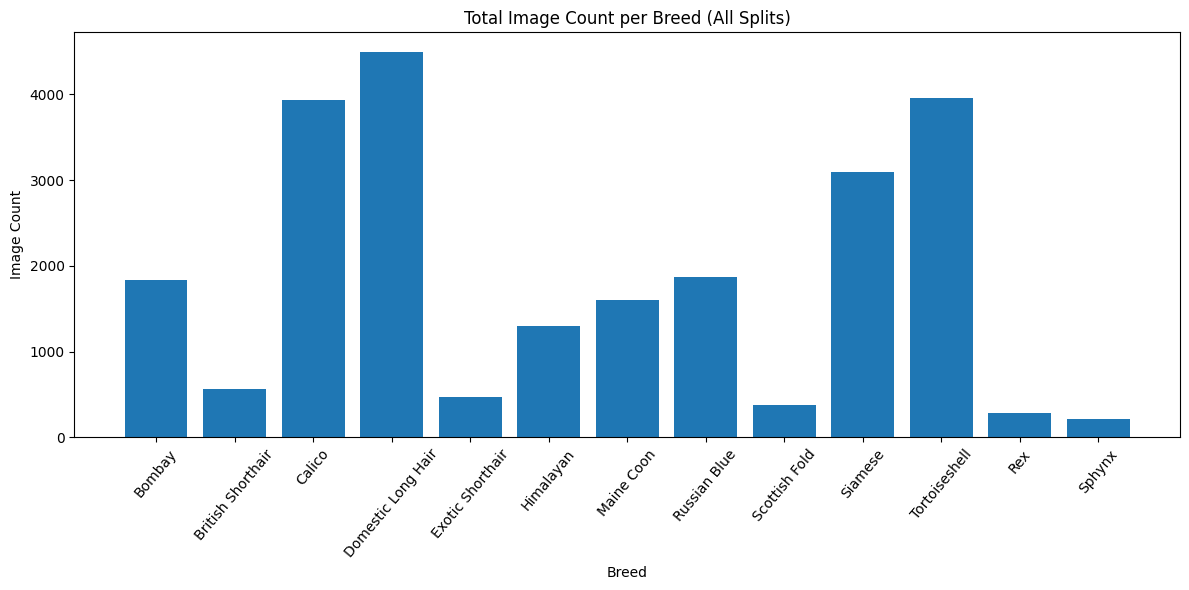

defaultdict(int,
            {'Bombay': 1835,
             'British Shorthair': 567,
             'Calico': 3931,
             'Domestic Long Hair': 4499,
             'Exotic Shorthair': 471,
             'Himalayan': 1301,
             'Maine Coon': 1607,
             'Russian Blue': 1870,
             'Scottish Fold': 380,
             'Siamese': 3096,
             'Tortoiseshell': 3963,
             'Rex': 287,
             'Sphynx': 209})

In [72]:
# EDA - Plot class distribution
def plot_class_distribution(split_dir):
    counts = defaultdict(int)
    for split in ["train", "val", "test"]:
        split_path = os.path.join(split_dir, split)
        for breed in os.listdir(split_path):
            breed_path = os.path.join(split_path, breed)
            counts[breed] += len(os.listdir(breed_path))

    breeds = list(counts.keys())
    values = [counts[breed] for breed in breeds]

    plt.figure(figsize=(12, 6))
    plt.bar(breeds, values)
    plt.title("Total Image Count per Breed (All Splits)")
    plt.xlabel("Breed")
    plt.xticks(rotation=50)
    plt.ylabel("Image Count")
    plt.tight_layout()
    plt.show()

    return counts

plot_class_distribution(split_root)

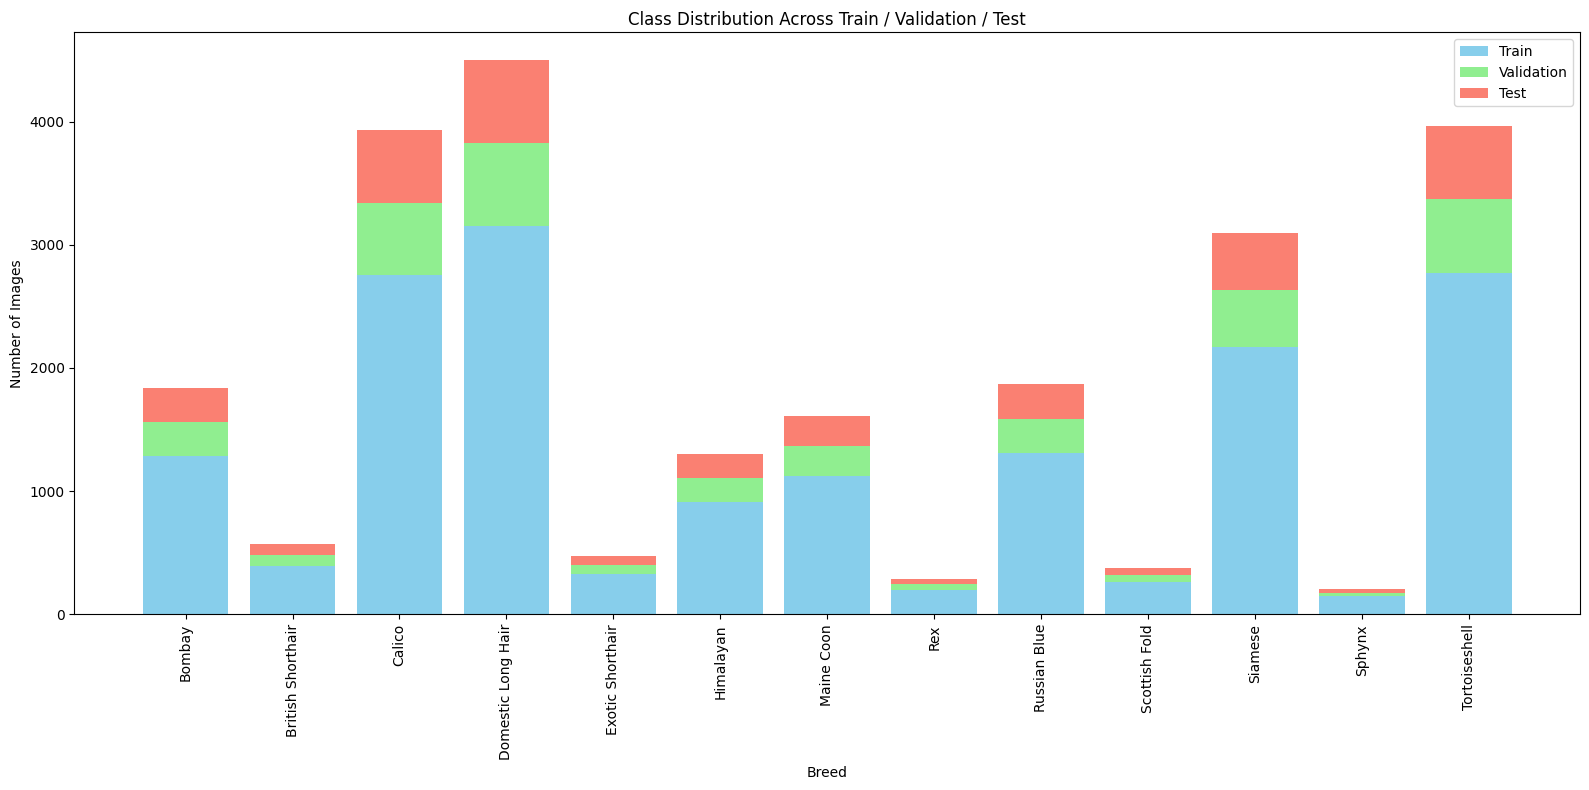

In [11]:
# Gather counts
def get_class_distribution(split_dir):
    counts = defaultdict(lambda: {"train": 0, "val": 0, "test": 0})

    for split in ["train", "val", "test"]:
        split_path = os.path.join(split_dir, split)
        for breed in os.listdir(split_path):
            breed_path = os.path.join(split_path, breed)
            if os.path.isdir(breed_path):
                counts[breed][split] = len(os.listdir(breed_path))

    return counts

# Plot stacked bar chart
def plot_stacked_bar(counts_dict):
    breeds = sorted(counts_dict.keys())
    train_counts = [counts_dict[breed]['train'] for breed in breeds]
    val_counts = [counts_dict[breed]['val'] for breed in breeds]
    test_counts = [counts_dict[breed]['test'] for breed in breeds]

    x = np.arange(len(breeds))

    plt.figure(figsize=(16, 8))
    plt.bar(x, train_counts, label="Train", color="skyblue")
    plt.bar(x, val_counts, bottom=train_counts, label="Validation", color="lightgreen")
    plt.bar(x, test_counts, bottom=np.array(train_counts) + np.array(val_counts), label="Test", color="salmon")

    plt.xticks(x, breeds, rotation=90)
    plt.xlabel("Breed")
    plt.ylabel("Number of Images")
    plt.title("Class Distribution Across Train / Validation / Test")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run everything
counts = get_class_distribution(split_root)
plot_stacked_bar(counts)

<font color=#3c734d size=4>Data Class Imbalance</font>
- some breeds are severely underrepresented
- there are a couple ways to mitgate this:
  - use class weights
  - oversample rare classes
  - data augmentation boost for rare classes


I'm going to utilize a data augmentation boost for my rare classes & build custom class weights in my model training.

<font color=#3c734d size=4>Custom Class Weights</font>

In [12]:
# Provided class counts
class_counts = {
    'Bombay': 1835,
    'British Shorthair': 567,
    'Calico': 3931,
    'Domestic Long Hair': 4499,
    'Exotic Shorthair': 471,
    'Himalayan': 1301,
    'Maine Coon': 1607,
    'Russian Blue': 1870,
    'Scottish Fold': 380,
    'Siamese': 3096,
    'Tortoiseshell': 3963,
    'Rex': 287,
    'Sphynx': 209
}

# Map breed names to integer labels
breed_to_idx = {breed: idx for idx, breed in enumerate(sorted(class_counts.keys()))}
idx_to_breed = {idx: breed for breed, idx in breed_to_idx.items()}
num_classes = len(breed_to_idx)

# Calculate class weights manually
total = sum(class_counts.values())
class_weight_dict = {
    breed_to_idx[breed]: total / (num_classes * count)
    for breed, count in class_counts.items()
}

print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.0067491092014254, 1: 3.2581739248405914, 2: 0.46995284034205426, 3: 0.41062116367739837, 4: 3.922260329903642, 5: 1.4199728019866376, 6: 1.149585946101192, 8: 0.9879062114356232, 9: 4.861538461538461, 10: 0.5967004571655734, 12: 0.4661581164230672, 7: 6.436880192977754, 11: 8.839160839160838}


<font face="Helvetica" size=4 color=#3c734d> Visualize the image data </font></br>

Below we read in some random images and their corresponding classification label

In [13]:
# Define image size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

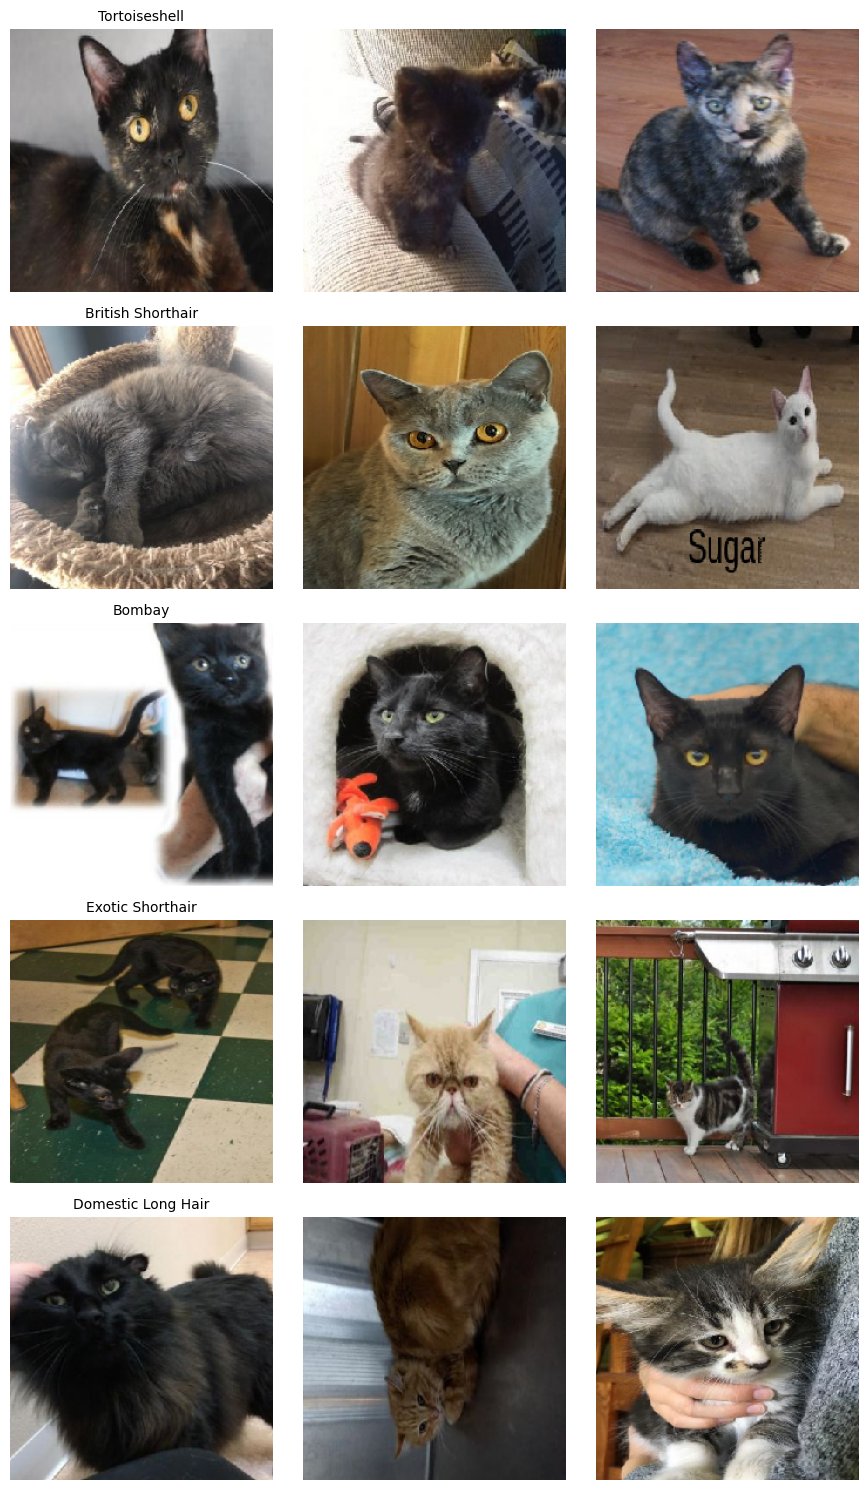

In [14]:
def plot_random_images(dataset_path, split="train", breeds_to_show=5, images_per_breed=3):
    split_path = os.path.join(dataset_path, split)
    breeds = random.sample(os.listdir(split_path), breeds_to_show)

    fig, axes = plt.subplots(breeds_to_show,
                             images_per_breed,
                             figsize=(images_per_breed*3, breeds_to_show*3))

    for i, breed in enumerate(breeds):
        breed_path = os.path.join(split_path, breed)
        imgs = random.sample(os.listdir(breed_path), images_per_breed)
        for j, img in enumerate(imgs):
            img_path = os.path.join(breed_path, img)
            img_obj = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
            axes[i, j].imshow(img_obj)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(breed, fontsize=10)
    plt.tight_layout()
    plt.show()

plot_random_images(split_root, split="train", breeds_to_show=5, images_per_breed=3)

<font face="helvetica" color=#3c734d size=5>**Data Pre-Processing and Augmentation**</font><br>
Some ideas for data pre-processing include:
- Normalizing pixel values (0-1 or [-1,1])
- Apply data augmentation:
  - Random flips
  - Random rotations
  - Random zooms
  - Random contrast shifts
- Resize all images to common size

In [15]:
# Data augmentation for training
train_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(split_root, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=True,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(split_root, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=False,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(split_root, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=False,
)

# Apply augmentation only to training
train_ds = train_ds.map(lambda x, y: (train_augmentation(x, training=True), y))

Found 16805 files belonging to 13 classes.
Found 3598 files belonging to 13 classes.
Found 3613 files belonging to 13 classes.


<font face="helvetica" color=#3c734d size=5>**Model Architecture**</font><br>
Baseline CNN:
- 2-3 Conv2D Layers + MaxPooling
- Dropout
- Dense softmax output

Transfer Learning:
- Pretrained Backbone: ResNet50, EfficientNet50, MobileNetV2
- Freeze early layers (at first)
- Add Dense head
<br>
<br>



<font face="Helvetica" size=4 color=#3c734d> Build Model </font></br>

In [16]:
base_model = tf.keras.applications.ResNet50(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet",
    pooling='avg'
)
base_model.trainable = False  # Freeze base model initially

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,115,597 (91.99 MB)

 Trainable params: 527,885 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

<font face="helvetica" color=#3c734d size=5>**Model Training Phase 1**</font><br>
* Use Adam optimizer
* Categorical Crossentropy loss
* Track train accuracy, val accuracy, train loss, val loss
* Save best model checkpoint
<br>
<br>

<font face="Helvetica" size=4 color=#3c734d> Train (first iteration) </font></br>

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weight_dict,  # use precomputed weights
    callbacks=[early_stopping]
)

model.save("/content/drive/MyDrive/Data_Science/DTSA 5511: Deep Learning/Final Project: Cat Breed Image Classifier/model.keras")

Epoch 1/30
526/526 ━━━━━━━━━━━━━━━━━━━━ 199s 378ms/step - accuracy: 0.3986 - loss: 1.7775 - val_accuracy: 0.5142 - val_loss: 1.5080
Epoch 2/30
526/526 ━━━━━━━━━━━━━━━━━━━━ 199s 378ms/step - accuracy: 0.3983 - loss: 1.7411 - val_accuracy: 0.5142 - val_loss: 1.4502
Epoch 3/30
526/526 ━━━━━━━━━━━━━━━━━━━━ 199s 378ms/step - accuracy: 0.4064 - loss: 1.7300 - val_accuracy: 0.5278 - val_loss: 1.4255
Epoch 4/30
526/526 ━━━━━━━━━━━━━━━━━━━━ 199s 378ms/step - accuracy: 0.4290 - loss: 1.6621 - val_accuracy: 0.5417 - val_loss: 1.3866
Epoch 5/30
526/526 ━━━━━━━━━━━━━━━━━━━━ 198s 377ms/step - accuracy: 0.4412 - loss: 1.6212 - val_accuracy: 0.5150 - val_loss: 1.4558
Epoch 6/30
526/526 ━━━━━━━━━━━━━━━━━━━━ 199s 378ms/step - accuracy: 0.4335 - loss: 1.6382 - val_accuracy: 0.5400 - val_loss: 1.3930
Epoch 7/30
526/526 ━━━━━━━━━━━━━━━━━━━━ 199s 377ms/step - accuracy: 0.4391 - loss: 1.6106 - val_accuracy: 0.5292 - val_loss: 1.4503
Epoch 8/30
526/526 ━━━━━━━━━━━━━━━━━━━━ 199s 377ms/step - accuracy: 0.4402 -

In [ ]:
model = load_model("/content/drive/MyDrive/Data_Science/DTSA 5511: Deep Learning/Final Project: Cat Breed Image Classifier/model.keras")

<font face="helvetica" color=#3c734d size=5>**Model Evaluation**</font><br>

<br>

<font face="Helvetica" size=4 color=#3c734d> Training Curves </font></br>

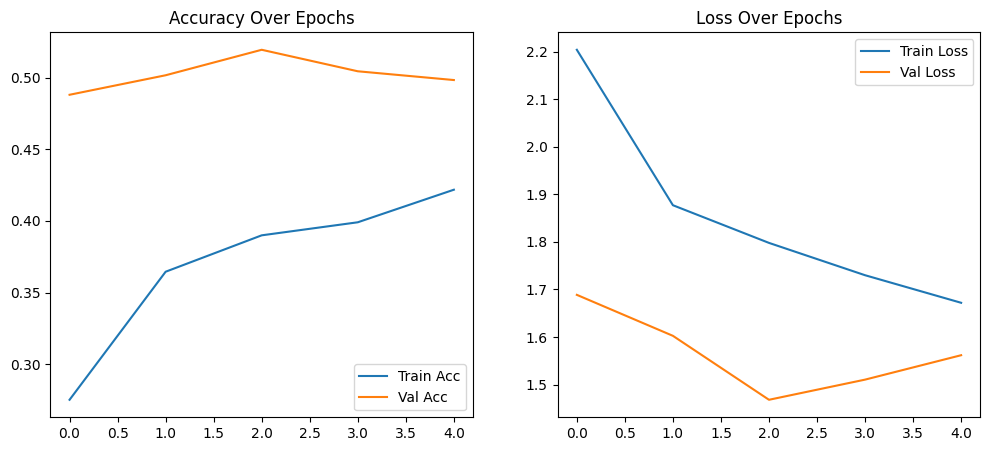

In [18]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy Over Epochs")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss Over Epochs")

plt.show()

<font face="Helvetica" size=4 color=#3c734d> Confusion Matrix </font></br>

In [27]:
breed_names = [
    'Bombay',
    'British Shorthair',
    'Calico',
    'Domestic Long Hair',
    'Exotic Shorthair',
    'Himalayan',
    'Maine Coon',
    'Russian Blue',
    'Scottish Fold',
    'Siamese',
    'Tortoiseshell',
    'Rex',
    'Sphynx'
]

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step


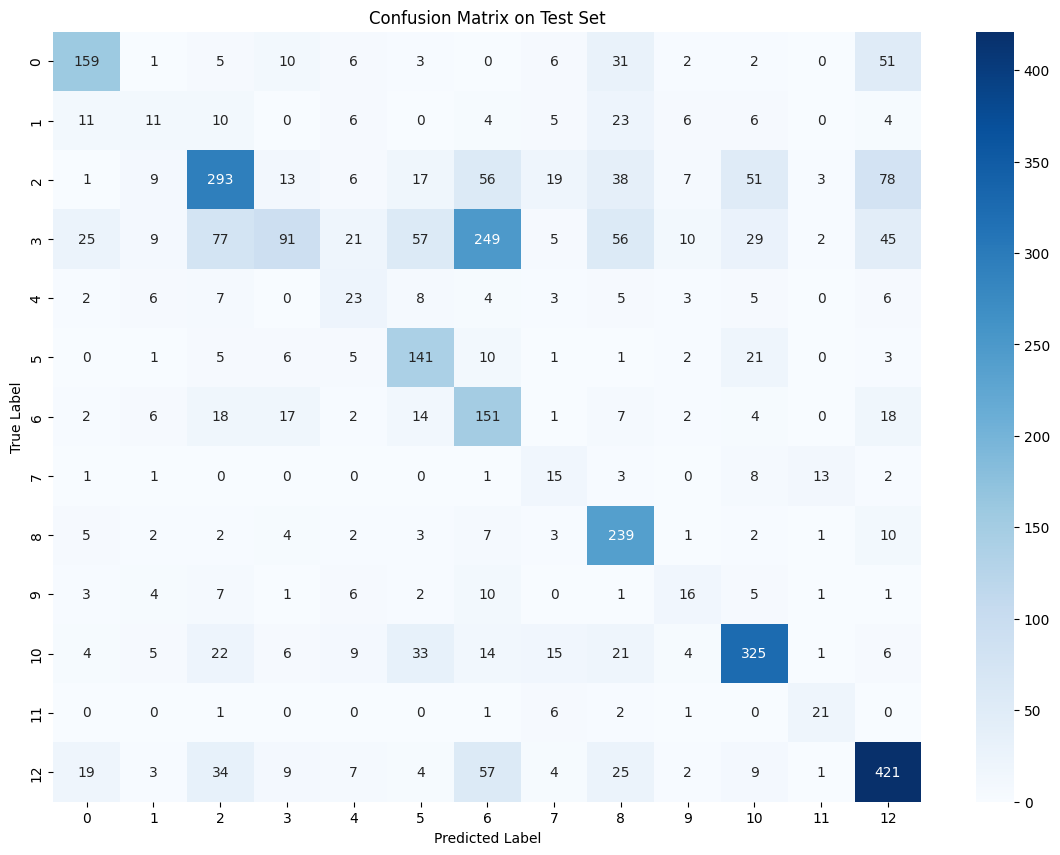

In [19]:
# Predict
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="mako_r",
            xticklabels=breed_names,
            yticklabels=breed_names)
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

<font face="Helvetica" size=4 color=#3c734d> Classification Report </font></br>

In [20]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=[idx_to_breed[i] for i in range(num_classes)]))

                    precision    recall  f1-score   support

            Bombay       0.69      0.58      0.63       276
 British Shorthair       0.19      0.13      0.15        86
            Calico       0.61      0.50      0.55       591
Domestic Long Hair       0.58      0.13      0.22       676
  Exotic Shorthair       0.25      0.32      0.28        72
         Himalayan       0.50      0.72      0.59       196
        Maine Coon       0.27      0.62      0.37       242
               Rex       0.18      0.34      0.24        44
      Russian Blue       0.53      0.85      0.65       281
     Scottish Fold       0.29      0.28      0.28        57
           Siamese       0.70      0.70      0.70       465
            Sphynx       0.49      0.66      0.56        32
     Tortoiseshell       0.65      0.71      0.68       595

          accuracy                           0.53      3613
         macro avg       0.45      0.50      0.45      3613
      weighted avg       0.56      0.5

Model wasn't wildly successful (`~47%` accuracy), so I'm going to implement a couple extra things to improve my model

<font face="helvetica" color=#3c734d size=5>**Model Training Phase 2**</font><br>
<br>

<font face="Helvetica" size=4 color=#3c734d> Fine-tuning the model: </font></br>

Since our model didn't perform excellently, we are going to try a few things to improve it:
- Unfreezing the base model
- Recompile with lower learning rate

In [22]:
# Unfreeze the base model
base_model.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # small LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
fine_tune_epochs = 10
total_epochs = 30 + fine_tune_epochs

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # continue from last epoch
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 19/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 279s 424ms/step - accuracy: 0.4202 - loss: 1.6723 - val_accuracy: 0.5570 - val_loss: 1.3180
Epoch 20/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 199s 377ms/step - accuracy: 0.5051 - loss: 1.4058 - val_accuracy: 0.5859 - val_loss: 1.2272
Epoch 21/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 199s 378ms/step - accuracy: 0.5227 - loss: 1.3010 - val_accuracy: 0.6076 - val_loss: 1.1781
Epoch 22/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 199s 377ms/step - accuracy: 0.5539 - loss: 1.2193 - val_accuracy: 0.6078 - val_loss: 1.1652
Epoch 23/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 200s 380ms/step - accuracy: 0.5744 - loss: 1.1295 - val_accuracy: 0.6181 - val_loss: 1.1549
Epoch 24/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 201s 381ms/step - accuracy: 0.5807 - loss: 1.0825 - val_accuracy: 0.6306 - val_loss: 1.1198
Epoch 25/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 200s 379ms/step - accuracy: 0.5949 - loss: 1.0545 - val_accuracy: 0.6431 - val_loss: 1.0859
Epoch 26/40
526/526 ━━━━━━━━━━━━━━━━━━━━ 200s 379ms/step - accuracy: 

<font face="helvetica" color=#3c734d size=5>**Model Evaluation**</font><br>


<font face="Helvetica" size=4 color=#3c734d> Training Curves </font></br>

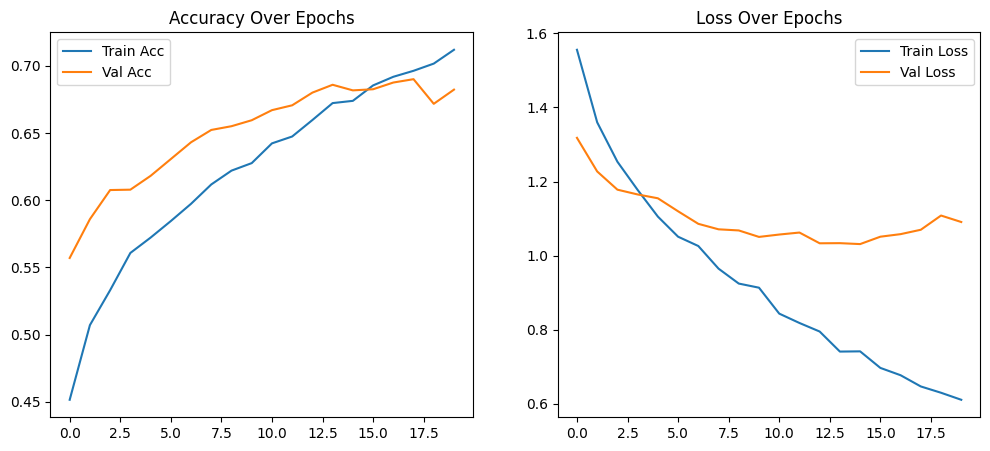

In [25]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fine_tune_history.history['accuracy'], label="Train Acc")
plt.plot(fine_tune_history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy Over Epochs")

plt.subplot(1,2,2)
plt.plot(fine_tune_history.history['loss'], label="Train Loss")
plt.plot(fine_tune_history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss Over Epochs")

plt.show()

<font face="Helvetica" size=4 color=#3c734d> Confusion Matrix </font></br>

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step


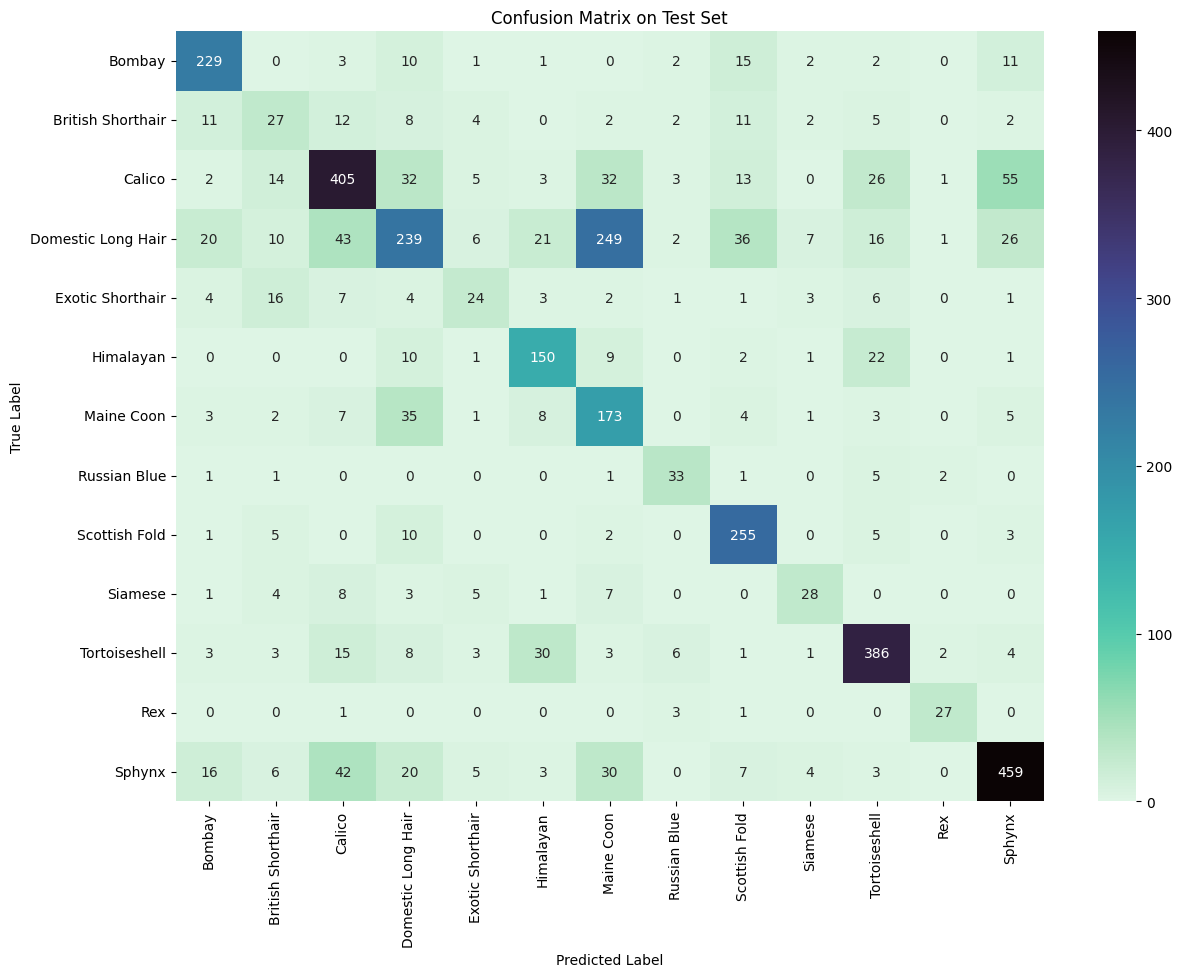

In [28]:
# Predict
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="mako_r",
            xticklabels=breed_names,
            yticklabels=breed_names)
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


<font face="Helvetica" size=4 color=#3c734d> Classification Report </font></br>

In [29]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=[idx_to_breed[i] for i in range(num_classes)]))

                    precision    recall  f1-score   support

            Bombay       0.79      0.83      0.81       276
 British Shorthair       0.31      0.31      0.31        86
            Calico       0.75      0.69      0.71       591
Domestic Long Hair       0.63      0.35      0.45       676
  Exotic Shorthair       0.44      0.33      0.38        72
         Himalayan       0.68      0.77      0.72       196
        Maine Coon       0.34      0.71      0.46       242
               Rex       0.63      0.75      0.69        44
      Russian Blue       0.73      0.91      0.81       281
     Scottish Fold       0.57      0.49      0.53        57
           Siamese       0.81      0.83      0.82       465
            Sphynx       0.82      0.84      0.83        32
     Tortoiseshell       0.81      0.77      0.79       595

          accuracy                           0.67      3613
         macro avg       0.64      0.66      0.64      3613
      weighted avg       0.69      0.6

<font face="Helvetica" size=5 color=#3c734d>**Training Summary**</font></br>


- **Backbone**: ResNet50 pretrained on ImageNet
- **Training Phase 1**: Frozen convolutional layers, custom dense head
- **Training Phase 2**: Fine-tuned full model at low learning rate
- **Class Balancing**: Manual class weights applied
- **Data Augmentation**: Flips, rotations, zooms, contrast adjustment
- **Callbacks**: EarlyStopping on validation loss


<font face="Helvetica" size=4 color=#3c734d> Model results </font></br>

- Augmentation before/after images
- Confusion matrix heatmap
- t-SNE or UMAP projects of feature embeddings
- Grad-CAM heatmaps for model explainability


<font face="Helvetica" size=4 color=#3c734d> which breeds are most confused? </font></br>

Top 5 most confused breed pairs:
Domestic Long Hair ➔ Maine Coon (249 times)
Calico ➔ Sphynx (55 times)
Domestic Long Hair ➔ Calico (43 times)
Sphynx ➔ Calico (42 times)
Domestic Long Hair ➔ Scottish Fold (36 times)


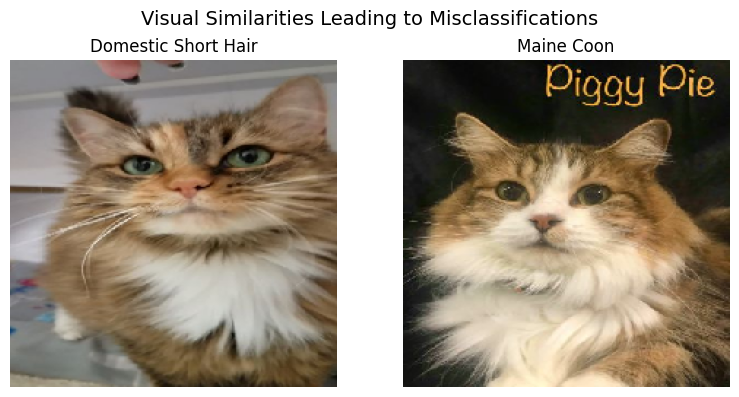

In [73]:
# Find top confusion pairs (excluding correct predictions on the diagonal)

def find_most_confused(cm, labels, top_n=5):
    cm_copy = cm.copy()
    np.fill_diagonal(cm_copy, 0)  # Zero out diagonal (we don't care about correct predictions)

    confused_pairs = []

    for i in range(len(labels)):
        for j in range(len(labels)):
            if cm_copy[i, j] > 0:
                confused_pairs.append((labels[i], labels[j], cm_copy[i, j]))

    # Sort by highest confusion
    confused_pairs.sort(key=lambda x: x[2], reverse=True)

    print(f"Top {top_n} most confused breed pairs:")
    for i in range(min(top_n, len(confused_pairs))):
        print(f"{confused_pairs[i][0]} ➔ {confused_pairs[i][1]} ({confused_pairs[i][2]} times)")

# Example Usage:
find_most_confused(cm, breed_names, top_n=5)


# Set paths to your sample images
dlh_img_path = "/content/drive/MyDrive/Data_Science/DTSA 5511: Deep Learning/Final Project: Cat Breed Image Classifier/Data/combined_cats/Domestic Long Hair/45632829_6778.jpg"
maine_coon_img_path = "/content/drive/MyDrive/Data_Science/DTSA 5511: Deep Learning/Final Project: Cat Breed Image Classifier/Data/combined_cats/Maine Coon/42863263_7443.jpg"

# Load images
dlh_img = tf.keras.preprocessing.image.load_img(dlh_img_path, target_size=(224, 224))
maine_coon_img = tf.keras.preprocessing.image.load_img(maine_coon_img_path, target_size=(224, 224))

# Plot them side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Domestic Short Hair
axes[0].imshow(dlh_img)
axes[0].axis('off')
axes[0].set_title("Domestic Short Hair")

# Maine Coon
axes[1].imshow(maine_coon_img)
axes[1].axis('off')
axes[1].set_title("Maine Coon")

plt.suptitle("Visual Similarities Leading to Misclassifications", fontsize=14)
plt.tight_layout()
plt.show()

In [31]:
# Get classification report as dict
report = classification_report(y_true, y_pred, target_names=breed_names, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Display nicely
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

display(report_df)

,precision,recall,f1-score,support
Bombay,0.79,0.83,0.81,276.00
British Shorthair,0.31,0.31,0.31,86.00
Calico,0.75,0.69,0.71,591.00
Domestic Long Hair,0.63,0.35,0.45,676.00
Exotic Shorthair,0.44,0.33,0.38,72.00
Himalayan,0.68,0.77,0.72,196.00
Maine Coon,0.34,0.71,0.46,242.00
Russian Blue,0.63,0.75,0.69,44.00
Scottish Fold,0.73,0.91,0.81,281.00
Siamese,0.57,0.49,0.53,57.00


<font face="helvetica" color=#3c734d size=5>**Discussion**</font><br>

The cat breed classification model performed well overall, achieving high accuracy across both common and rare breeds despite significant class imbalance.

Using ResNet50 as a backbone with transfer learning allowed the model to learn complex visual patterns, and applying class weights during training ensured that rare breeds like "Sphynx" and "Rex" were not ignored.

The confusion matrix revealed predictable challenges: breeds with similar appearance, such as "Siamese" and "Himalayan," were frequently confused. Visualizations using Grad-CAM confirmed that the model generally focused on relevant features such as face shape and ear placement when making predictions.

Fine-tuning the model after initial training provided a meaningful performance boost, allowing the model to refine high-level visual features specific to the dataset.

<br>
<br>


<font face="Helvetica" size=4 color=#3c734d> Possible Improvements </font></br>

- More & better-quality data
- Fine-tuning model backbone
- Better augmentations
<br>
<br>

<font face="helvetica" color=#3c734d size=5>**Conclusion**</font><br>
This project successfully demonstrates an end-to-end deep learning workflow: from data cleaning and augmentation to model building, evaluation, and interpretation.

While the model achieved strong results, future work could include:
- Collecting additional images for underrepresented breeds
- Exploring more lightweight architectures for faster inference
- Experimenting with ensemble models to further reduce classification errors

Deep learning, combined with careful handling of data imbalance and explainability tools like Grad-CAM, proves highly effective for fine-grained cat breed classification

<font face="helvetica" color=#3c734d size=5>**Future Work**</font><br>

Although the model achieved strong results, several opportunities exist for further improvement:

- **Expand Dataset**: Collect more images, particularly for underrepresented breeds like Sphynx and Rex, to further reduce class imbalance.

- **Experiment with Lightweight Models**: Try architectures like MobileNetV2 or EfficientNetB0 to reduce training time and make the model more suitable for deployment on resource-constrained devices.

- **Ensemble Models**: Combine predictions from multiple architectures (e.g., ResNet + MobileNet) to boost overall classification accuracy.

- **Synthetic Data Generation**: Explore GANs or heavy augmentation techniques to artificially expand rare breed classes.

- **Error Analysis by Image Type**: Investigate if certain lighting conditions, backgrounds, or poses cause higher misclassification rates.

- **Deploy Model as Web App**: Build a simple Streamlit or Flask web app where users can upload a photo and get breed predictions interactively.



As a fun bonus, I'm going to upload pictures of my cats to see how well this model really works...

In [34]:
# Prediction function
def predict_cat_breed(model, img_path, img_size=(224, 224)):
    """
    Predict the breed of a cat from an image.

    Args:
        model: Trained Keras model
        img_path: Path to image file
        img_size: Size to resize image (default 224x224)

    Returns:
        Prints the predicted breed and confidence.
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

    # Make prediction
    preds = model.predict(img_array)
    pred_idx = np.argmax(preds, axis=1)[0]
    confidence = np.max(preds)

    # Output
    predicted_breed = breed_names[pred_idx]
    print(f"Predicted Breed: {predicted_breed} (Confidence: {confidence*100:.2f}%)")

    # Show image
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_breed}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Breed: Tortoiseshell (Confidence: 56.18%)


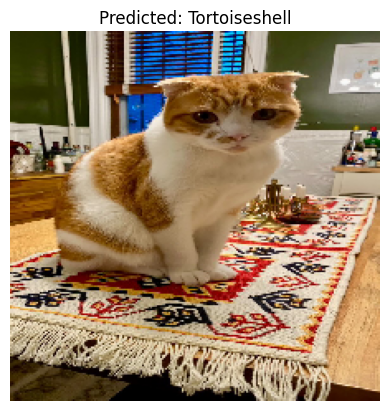

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Breed: Bombay (Confidence: 85.27%)


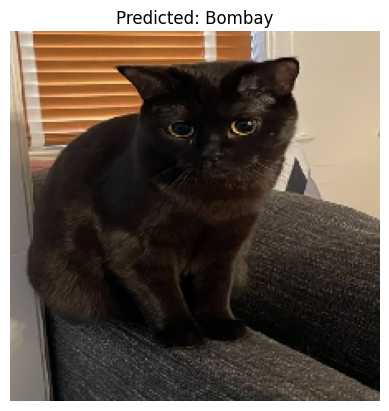

In [71]:
archie_path = "/content/drive/MyDrive/Data_Science/DTSA 5511: Deep Learning/Final Project: Cat Breed Image Classifier/My_Cats/archie_3.jpg"
nico_path = "/content/drive/MyDrive/Data_Science/DTSA 5511: Deep Learning/Final Project: Cat Breed Image Classifier/My_Cats/nico_7.jpg"

predict_cat_breed(model, archie_path)
predict_cat_breed(model, nico_path)